In [1]:
import numpy as np
import pandas as pd
from classify_scores import classify
from calculate_score import density_factor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

In [3]:
data_path = 'classifier_dataset_lesion_dilate_it=5_dilate_k=7.csv'

fake_gated_df = pd.read_csv(os.path.join('data/EXAMES/Classifiers_Dataset/Fake_Gated/avg=4/130', data_path))
# gated_df = pd.read_csv(os.path.join('data/EXAMES/Classifiers_Dataset/Gated', data_path))

In [4]:
print(fake_gated_df.head())
# print(gated_df.head())

   patient      Max HU  Centroid X  Centroid Y  Area  Area Pixel Spacing  \
0    74657  172.443244  359.000000       367.0    13            0.466489   
1    74657  180.925625  357.000000       364.2    10            0.466489   
2    74657  132.245077  296.500000       263.0     2            0.466489   
3    74657  188.465533  297.705882       272.0    17            0.466489   
4    74657  135.457184  298.000000       278.0     1            0.466489   

   Channel  Escore  
0       41   725.0  
1       42   725.0  
2       49   725.0  
3       49   725.0  
4       49   725.0  


In [5]:
print(fake_gated_df[['patient', 'Area']].drop_duplicates().shape)
# print(gated_df[['patient', 'Area']].drop_duplicates().shape)
# print(avg_area_dif)

print(fake_gated_df['patient'].drop_duplicates().values)
# print(gated_df['patient'].drop_duplicates().values)

print(fake_gated_df['patient'].drop_duplicates().shape)
# print(gated_df['patient'].drop_duplicates().shape)

(95, 2)
[ 74657 176253 180545 177031 175918  80376 180042 174732 182074 175404
 175056 180466 182661 176063 176726 182447 174030 179970 180386 177233
 175420  11517]
(22,)


In [81]:
# Filter patients that are in both datasets
fake_gated_df = pd.merge(fake_gated_df, gated_df['patient'].drop_duplicates(), on='patient', how='right').dropna()
# fake_gated_df = fake_gated_df[fake_gated_df['patient'].isin(gated_df['patient'].drop_duplicates().values)]
print(fake_gated_df['patient'].drop_duplicates().shape)
print(gated_df['patient'].drop_duplicates().shape)

gated_df = pd.merge(gated_df, fake_gated_df['patient'].drop_duplicates(), on='patient', how='right').dropna()
print(gated_df['patient'].drop_duplicates().shape)

(25,)
(30,)
(25,)


In [82]:
print(fake_gated_df.head())

   patient      Max HU  Centroid X  Centroid Y  Area  Area Pixel Spacing  \
1    74657  168.865927  380.500000  412.000000   8.0            0.466489   
2    74657  592.644384  361.000000  389.365079  63.0            0.466489   
3    74657  158.373585  315.200000  309.000000  25.0            0.466489   
4    74657  131.681918  330.000000  338.000000   1.0            0.466489   
5    74657  168.654141  308.285714  289.000000   7.0            0.466489   

   Channel  Escore  
1     54.0   725.0  
2     61.0   725.0  
3     66.0   725.0  
4     66.0   725.0  
5     67.0   725.0  


In [6]:
# Estimate Agatston Escore
fake_gated_df['Density Factor'] = fake_gated_df['Max HU'].apply(lambda x: density_factor(x))
# gated_df['Density Factor'] = gated_df['Max HU'].apply(lambda x: density_factor(x))

fake_gated_df['Estimated Agatston'] = fake_gated_df['Density Factor'] * fake_gated_df['Area'] * fake_gated_df['Area Pixel Spacing']
# gated_df['Agatston'] = gated_df['Density Factor'] * gated_df['Area']

fake_gated_df.set_index('patient', inplace=True)
fake_gated_df['Estimated Global Agatston'] = fake_gated_df.groupby('patient')['Estimated Agatston'].transform('sum')
fake_gated_df['Estimated Global Agatston'] = 40 * (fake_gated_df['Estimated Global Agatston'] / fake_gated_df.groupby('patient')['Channel'].transform('max'))


In [131]:
print(fake_gated_df.head())

             Max HU  Centroid X  Centroid Y  Area  Area Pixel Spacing  \
patient                                                                 
74657    168.865927  380.500000  412.000000     8            0.466489   
74657    592.644384  361.000000  389.365079    63            0.466489   
74657    158.373585  315.200000  309.000000    25            0.466489   
74657    131.681918  330.000000  338.000000     1            0.466489   
74657    168.654141  308.285714  289.000000     7            0.466489   

         Channel  Escore  Density Factor  Estimated Agatston  \
patient                                                        
74657         54   725.0               1            3.731912   
74657         61   725.0               4          117.555241   
74657         66   725.0               1           11.662226   
74657         66   725.0               1            0.466489   
74657         67   725.0               1            3.265423   

         Estimated Global Agatston  
pa

In [7]:
agatston_preds_labels = fake_gated_df[['Estimated Global Agatston', 'Escore']].copy()

agatston_preds_labels['Escore Clssf'] = agatston_preds_labels['Escore'].apply(lambda x: classify(x))
agatston_preds_labels['Agatston Clssf'] = agatston_preds_labels['Estimated Global Agatston'].apply(lambda x: classify(x))

f1_score = f1_score(agatston_preds_labels['Escore Clssf'], agatston_preds_labels['Agatston Clssf'].values, average='weighted')
accuracy = accuracy_score(agatston_preds_labels['Escore Clssf'], agatston_preds_labels['Agatston Clssf'].values)

print(f1_score, accuracy)

0.42956571146562106 0.44660194174757284


In [72]:
# class_names = ['sem_risco', 'risco_intermediario', 'alto_risco']

# # Compute confusion matrix for ROI Gated
# cm = confusion_matrix(agatston_preds_labels['Escore Clssf'].values, agatston_preds_labels['Agatston Clssf'].values, normalize='true')
# cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
# # Plot the confusion matrix
# figure = plt.figure(figsize=(9,6))
# sns.heatmap(cm_df, annot=True, cmap='Blues')
# plt.title(f'ROI Confusion Matrix dilated_it=5_k=5')
# plt.ylabel('Actual Class')
# plt.xlabel('Predicted Class')
# plt.show()

In [83]:
# Calculate the sum of Max HU for each pacient and divide by the number of slices
# fake_gated_df['Sum Max HU'] = fake_gated_df.groupby('patient')['Max HU'].transform('sum') / fake_gated_df.groupby('patient')['Channel'].transform('max')
# gated_df['Sum Max HU'] = gated_df.groupby('Pacient')['Max HU'].transform('sum') / gated_df.groupby('Pacient')['Channel'].transform('max')

fake_gated_df['Sum Max HU'] = fake_gated_df.groupby('patient')['Max HU'].transform('sum') / fake_gated_df.groupby('patient')['Max HU'].transform('count')
gated_df['Sum Max HU'] = gated_df.groupby('patient')['Max HU'].transform('sum') / gated_df.groupby('patient')['Max HU'].transform('count')

# Calculate the sum of Area for each pacient and divide by the number of slices
# fake_gated_df['Sum Area'] = fake_gated_df.groupby('patient')['Area'].transform('sum') / fake_gated_df.groupby('patient')['Channel'].transform('max')
# gated_df['Sum Area'] = gated_df.groupby('Pacient')['Area'].transform('sum') / gated_df.groupby('Pacient')['Channel'].transform('max')

fake_gated_df['Avg Area'] = fake_gated_df.groupby('patient')['Area'].transform('sum') / fake_gated_df.groupby('patient')['Area'].transform('count')
gated_df['Avg Area'] = gated_df.groupby('patient')['Area'].transform('sum') / gated_df.groupby('patient')['Area'].transform('count')

In [84]:
print(fake_gated_df.head())
# print(gated_df.head())

   patient      Max HU  Centroid X  Centroid Y  Area  Area Pixel Spacing  \
1    74657  168.865927  380.500000  412.000000   8.0            0.466489   
2    74657  592.644384  361.000000  389.365079  63.0            0.466489   
3    74657  158.373585  315.200000  309.000000  25.0            0.466489   
4    74657  131.681918  330.000000  338.000000   1.0            0.466489   
5    74657  168.654141  308.285714  289.000000   7.0            0.466489   

   Channel  Escore  Sum Max HU   Avg Area  
1     54.0   725.0  233.247766  52.153846  
2     61.0   725.0  233.247766  52.153846  
3     66.0   725.0  233.247766  52.153846  
4     66.0   725.0  233.247766  52.153846  
5     67.0   725.0  233.247766  52.153846  


In [85]:
avg_area_dif = pd.merge(fake_gated_df[['patient', 'Avg Area']].drop_duplicates(), gated_df[['patient', 'Avg Area']].drop_duplicates(), on='patient', suffixes=('_fake_gated', '_gated'), how='right')

In [87]:
# Remove patient with Nan values
avg_area_dif = avg_area_dif.dropna()
print(avg_area_dif.head())
avg_area_dif['Avg Area Dif'] = avg_area_dif['Avg Area_fake_gated'] - avg_area_dif['Avg Area_gated']

   patient  Avg Area_fake_gated  Avg Area_gated
0    74657            52.153846       51.842105
1   176253            53.368421       37.153846
2   180545            17.500000       23.111111
3   177031            42.142857       24.833333
4   175918            66.857143        8.750000


In [91]:
print(fake_gated_df.groupby('patient')['Channel'].transform('max').drop_duplicates().values)
channels_fg = fake_gated_df.groupby('patient')['Channel'].transform('max').drop_duplicates().values * 3
print(np.mean(channels_fg))
print(gated_df.groupby('patient')['Channel'].transform('max').drop_duplicates().values)
channels_g = gated_df.groupby('patient')['Channel'].transform('max').drop_duplicates().values
print(np.mean(channels_g))

[134. 100.  39.  71. 101.  55. 126. 115.  63. 112. 138.  81. 117.  70.
  32. 141.  51. 135.  47. 106. 130.  90.]
280.09090909090907
[35 29 25 28 27 24 10 30 22 31 32  0 20 26 33 23 43]
25.764705882352942


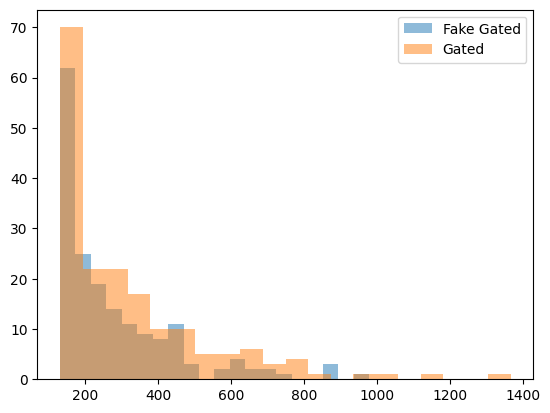

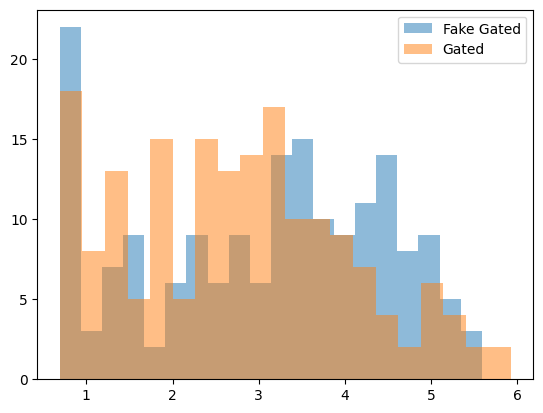

DEBUG
46.2090395480226 53.974071296945404
34.88268156424581 57.83978920467056


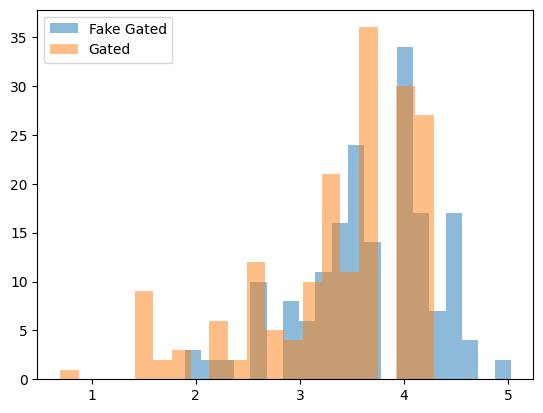

46.2090395480226
34.88268156424581


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


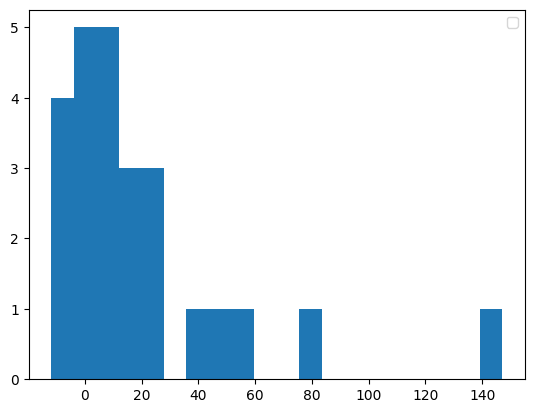

In [88]:
# Get the 3 patients with the highest escore
# highest_escore_patients = gated_df.sort_values(by='Escore', ascending=False)['patient'].drop_duplicates().head(3).values
# print(highest_escore_patients)
# print(highest_escore_patients[0])
# print(fake_gated_df['patient'].isin(highest_escore_patients[0]))
fake_gated_lesions = fake_gated_df
gated_lesions = gated_df
# print(fake_gated_lesions.head())
# print(gated_lesions['Agatston'].sum())
# print(fake_gated_lesions['Agatston'].sum())
# Plot both hgistograms
plt.figure()
plt.hist(fake_gated_lesions['Max HU'], bins=20, alpha=0.5, label='Fake Gated')
plt.hist(gated_lesions['Max HU'], bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.log1p(fake_gated_lesions['Area']), bins=20, alpha=0.5, label='Fake Gated')
plt.hist(np.log1p(gated_lesions['Area']), bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()
print('DEBUG')
print(fake_gated_lesions['Area'].mean(), fake_gated_lesions['Area'].std())
print(gated_lesions['Area'].mean(), gated_lesions['Area'].std())

plt.figure()
plt.hist(np.log1p(fake_gated_lesions['Avg Area']), bins=20, alpha=0.5, label='Fake Gated')
plt.hist(np.log1p(gated_lesions['Avg Area']), bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

print(fake_gated_lesions['Avg Area'].mean())
print(gated_lesions['Avg Area'].mean())

plt.figure()
plt.hist(avg_area_dif['Avg Area Dif'], bins=20)
# plt.hist(abs(np.log1p(fake_gated_lesions['Avg Area']) - np.log1p(gated_lesions['Avg Area'])), bins=20)
plt.legend()
plt.show()

In [61]:
print(gated_df.head())

   Pacient  Max HU  Centroid X  Centroid Y      Area  Channel  Escore  \
0   183077   133.0       176.0       309.0  0.184041        0     7.0   
1   183077   138.0       179.0       299.0  0.184041        0     7.0   
2   183077   132.0       179.0       347.0  0.184041        0     7.0   
3   183077   146.0       197.0       360.0  0.184041        0     7.0   
4   183077   130.0       203.0       314.0  0.184041        0     7.0   

   Density Factor  Agatston  
0               1  0.184041  
1               1  0.184041  
2               1  0.184041  
3               1  0.184041  
4               1  0.184041  


[176253  74657 175056]
176253
791.002226314831


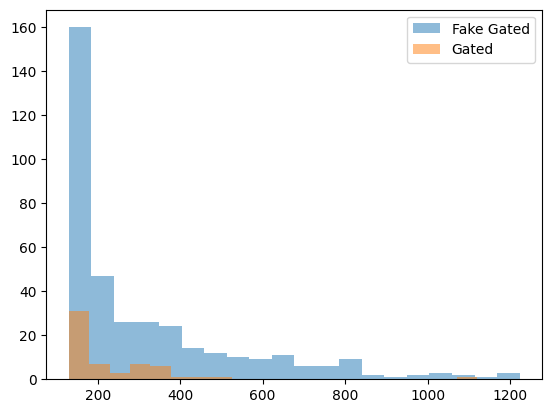

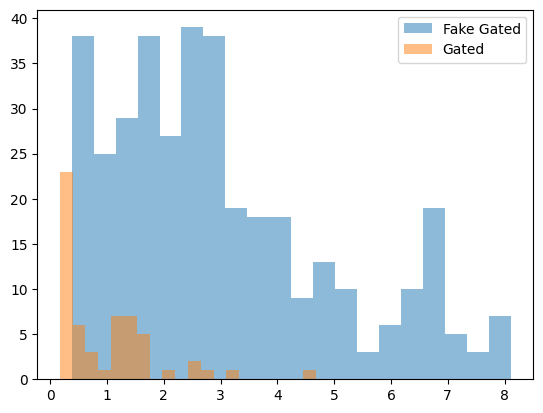

In [65]:
# Get the 3 patients with the highest escore
highest_escore_patients = gated_df.sort_values(by='Escore', ascending=False)['Pacient'].drop_duplicates().head(3).values
print(highest_escore_patients)
print(highest_escore_patients[0])
# print(fake_gated_df['patient'].isin(highest_escore_patients[0]))
fake_gated_lesions = fake_gated_df[fake_gated_df['patient'] == highest_escore_patients[0]]
gated_lesions = gated_df[gated_df['Pacient'] == highest_escore_patients[0]]
# print(fake_gated_lesions.head())
print(gated_lesions['Agatston'].sum())
# Plot both hgistograms
plt.figure()
plt.hist(fake_gated_lesions['Max HU'], bins=20, alpha=0.5, label='Fake Gated')
plt.hist(gated_lesions['Max HU'], bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.log1p(fake_gated_lesions['Area']), bins=20, alpha=0.5, label='Fake Gated')
plt.hist(np.log1p(gated_lesions['Area']), bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

[176253  74657 175056]
74657
2288.8771761456974


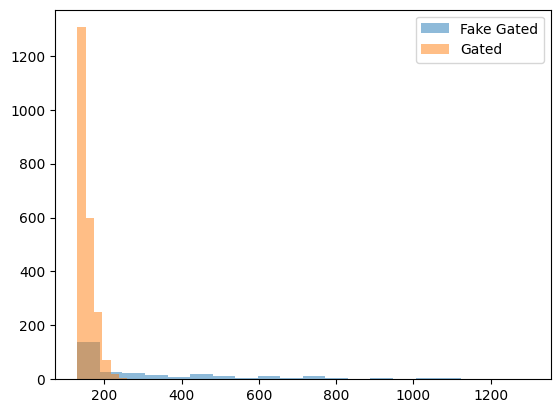

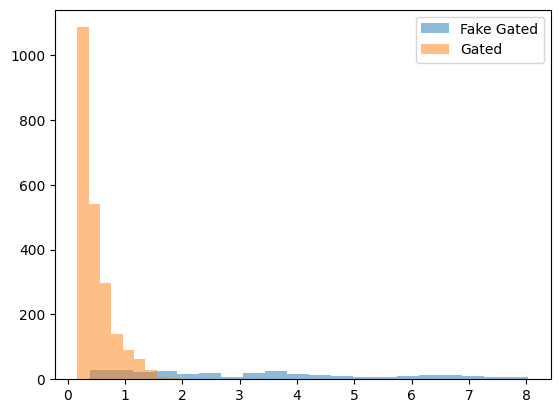

In [64]:
# Get the 3 patients with the highest escore
highest_escore_patients = gated_df.sort_values(by='Escore', ascending=False)['Pacient'].drop_duplicates().head(3).values
print(highest_escore_patients)
print(highest_escore_patients[1])
# print(fake_gated_df['patient'].isin(highest_escore_patients[0]))
fake_gated_lesions = fake_gated_df[fake_gated_df['patient'] == highest_escore_patients[1]]
gated_lesions = gated_df[gated_df['Pacient'] == highest_escore_patients[1]]
# print(fake_gated_lesions.head())
print(gated_lesions['Agatston'].sum())
# Plot both hgistograms
plt.figure()
plt.hist(fake_gated_lesions['Max HU'], bins=20, alpha=0.5, label='Fake Gated')
plt.hist(gated_lesions['Max HU'], bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.log1p(fake_gated_lesions['Area']), bins=20, alpha=0.5, label='Fake Gated')
plt.hist(np.log1p(gated_lesions['Area']), bins=20, alpha=0.5, label='Gated')
plt.legend()
plt.show()

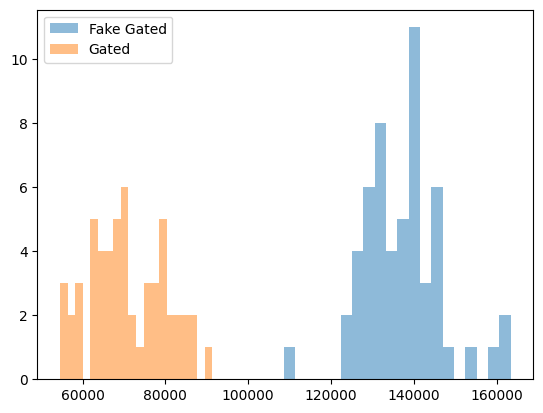

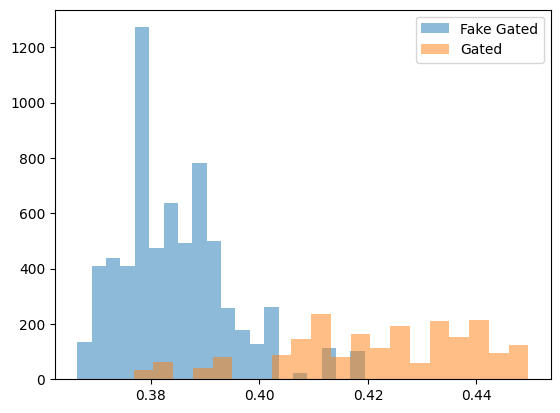

In [112]:
blur_metrics_path = 'blur_metrics.csv'
blur_metrics_fake_gated = pd.read_csv(os.path.join('data/EXAMES/Blur_measures/Fake_Gated', blur_metrics_path))
blur_metrics_gated = pd.read_csv(os.path.join('data/EXAMES/Blur_measures/Gated', blur_metrics_path))

# print(blur_metrics_fake_gated.head())

# Take the mean of the sharpness score for each patient divided by the number of slices
blur_metrics_fake_gated['avg_sharp_score'] = blur_metrics_fake_gated.groupby('Patient')['sharp_score'].transform('mean')
blur_metrics_gated['avg_sharp_score'] = blur_metrics_gated.groupby('Patient')['sharp_score'].transform('mean')

blur_metrics_fake_gated['avg_blur_metric'] = blur_metrics_fake_gated.groupby('Patient')['blur_metric'].transform('mean')
blur_metrics_gated['avg_blur_metric'] = blur_metrics_gated.groupby('Patient')['blur_metric'].transform('mean')

# Plot both histograms
plt.figure()
plt.hist(blur_metrics_fake_gated['avg_sharp_score'].drop_duplicates(), bins=20, alpha=0.5, label='Fake Gated')
plt.hist(blur_metrics_gated['avg_sharp_score'].drop_duplicates(), bins=20, alpha=0.5, label='Gated')
plt.legend()

plt.figure()
plt.hist(blur_metrics_fake_gated['avg_blur_metric'], bins=20, alpha=0.5, label='Fake Gated')
plt.hist(blur_metrics_gated['avg_blur_metric'], bins=20, alpha=0.5, label='Gated')
plt.legend()



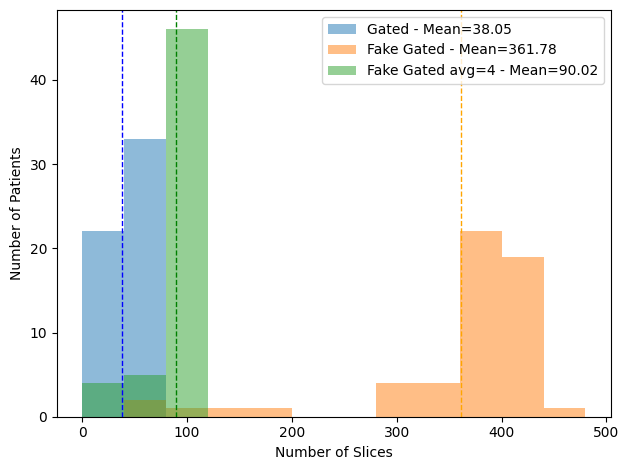

In [4]:
gated_path = 'data/EXAMES/number_slices_Gated.csv'
fake_gated_path = 'data/EXAMES/number_slices_FakeGated.csv'
fake_gated_avg3_path = 'data/EXAMES/number_slices_FakeGated_avg=4.csv'

# Plot the number of slices for each patient
gated_slices = pd.read_csv(gated_path)
fake_gated_slices = pd.read_csv(fake_gated_path)
fake_gated_avg3_slices = pd.read_csv(fake_gated_avg3_path)

mean_gated_slices = gated_slices['Number Slices'].mean()
mean_fake_gated_slices = fake_gated_slices['Number Slices'].mean()
mean_fake_gated_avg3_slices = fake_gated_avg3_slices['Number Slices'].mean()

# Define bin edges from 0 to 600 with a step of 40
bins = np.arange(0, 501, 40)

fig = plt.figure()
plt.hist(gated_slices['Number Slices'], bins=bins, alpha=0.5, label=f'Gated - Mean={mean_gated_slices:.2f}')
plt.hist(fake_gated_slices['Number Slices'], bins=bins, alpha=0.5, label=f'Fake Gated - Mean={mean_fake_gated_slices:.2f}')
plt.hist(fake_gated_avg3_slices['Number Slices'], bins=bins, alpha=0.5, label=f'Fake Gated avg=4 - Mean={mean_fake_gated_avg3_slices:.2f}')

plt.axvline(mean_gated_slices, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_fake_gated_slices, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(mean_fake_gated_avg3_slices, color='green', linestyle='dashed', linewidth=1)

plt.xlabel('Number of Slices')
plt.ylabel('Number of Patients')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('data/EXAMES/Experiments_Metrics/number_slices2.png', dpi=300)